In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # We'll use this for chronological split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load the data
df = pd.read_csv('AAPL_advanced_features.csv', index_col='Date', parse_dates=True)

# show coloumns
print("Columns in the dataset:")
print(df.columns)

Columns in the dataset:
Index(['Close', 'High', 'Low', 'Open', 'Volume', 'MACD', 'MACD_Signal',
       'MACD_Diff', 'EMA_12', 'EMA_26', 'ADX', 'ADX_pos', 'ADX_neg', 'BBL',
       'BBM', 'BBH', 'BB_bandwidth', 'BB_percent', 'ATR', 'RSI', 'Stoch_K',
       'Stoch_D', 'ROC', 'OBV', 'Prev_Close', 'SMA_10', 'Daily_Change_Pct',
       'Target'],
      dtype='object')


In [37]:
excluded_columns = ['Close', 'Daily_Change_Pct', 'Target', 'Open', 'High', 'Low', 'Volume']

feature_columns = [col for col in df.columns if col not in excluded_columns]

X = df[feature_columns]
y = df['Target']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nSelected Features:")
print(feature_columns)

Features (X) shape: (1223, 21)
Target (y) shape: (1223,)

Selected Features:
['MACD', 'MACD_Signal', 'MACD_Diff', 'EMA_12', 'EMA_26', 'ADX', 'ADX_pos', 'ADX_neg', 'BBL', 'BBM', 'BBH', 'BB_bandwidth', 'BB_percent', 'ATR', 'RSI', 'Stoch_K', 'Stoch_D', 'ROC', 'OBV', 'Prev_Close', 'SMA_10']


In [38]:
split_point = int(len(X) * 0.8) # 80% for training, 20% for testing

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Also get the actual closing prices for the test period for backtesting later
test_close_prices = df['Close'][split_point:] # Using 'Close' which is the original price column

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Train set date range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test set date range: {X_test.index.min()} to {X_test.index.max()}")


Training set size: 978 samples
Testing set size: 245 samples
Train set date range: 2020-02-20 00:00:00 to 2024-01-08 00:00:00
Test set date range: 2024-01-09 00:00:00 to 2024-12-27 00:00:00


In [39]:
# Initialize and train the Random Forest Classifier
# n_estimators: number of trees in the forest
# random_state: for reproducibility
# class_weight: useful for handling potential imbalances, even if minor
#               'balanced' automatically adjusts weights inversely proportional to class frequencies.
print("\n--- Training Random Forest Classifier ---")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1) # n_jobs=-1 uses all available cores
model.fit(X_train, y_train)

print("Model training complete.")


--- Training Random Forest Classifier ---
Model training complete.



--- Model Evaluation (Random Forest Classifier) ---
Accuracy: 0.4204

Classification Report:
              precision    recall  f1-score   support

        Down       0.40      0.70      0.51       104
          Up       0.49      0.21      0.30       141

    accuracy                           0.42       245
   macro avg       0.44      0.46      0.40       245
weighted avg       0.45      0.42      0.39       245



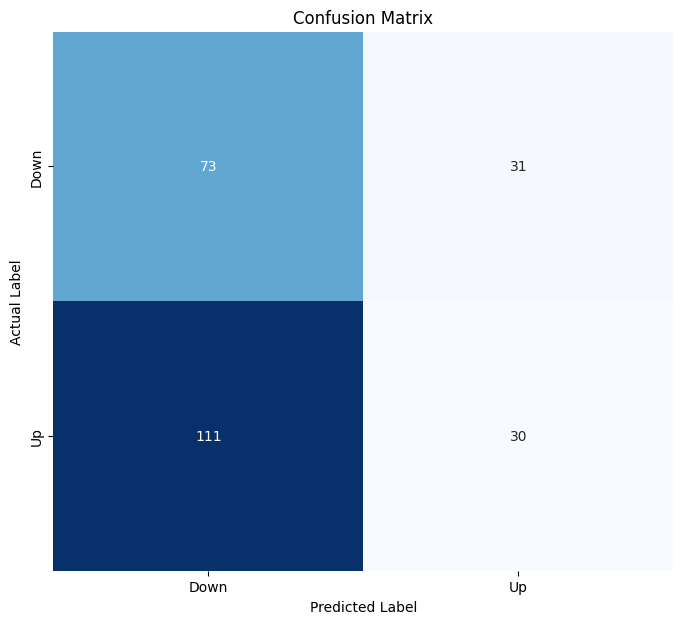

IndexError: index 2 is out of bounds for axis 1 with size 2

In [40]:
# Make predictions on the test set
predictions = model.predict(X_test)
prediction_probabilities = model.predict_proba(X_test) # Probabilities for all classes

# Evaluate the model
print("\n--- Model Evaluation (Random Forest Classifier) ---")
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print("\nClassification Report:")
# Target names are important for clarity in classification report
target_names = ['Down', 'Up'] # Assuming 0: Down, 1: Flat, 2: Up
print(classification_report(y_test, predictions, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- ROC Curve and AUC (for multi-class, it's typically "One-vs-Rest" or "One-vs-One") ---
# For simplicity, let's calculate AUC for the 'Up' class (class 2) vs others as a binary problem
# You can extend this for all classes if needed using more advanced ROC plotting techniques.
# For multi-class AUC, `roc_auc_score` with `multi_class='ovr'` or `multi_class='ovo'` is common.

# Probability of predicting 'Up' (class 2)
up_class_probabilities = prediction_probabilities[:, 2]

# Need to convert y_test to binary (1 if 'Up', 0 otherwise) for this specific AUC calculation
y_test_binary_up = (y_test == 2).astype(int)

fpr, tpr, thresholds = roc_curve(y_test_binary_up, up_class_probabilities)
auc = roc_auc_score(y_test_binary_up, up_class_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve for "Up" (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting "Up" (Class 2)')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC Score for 'Up' class: {auc:.4f}")

# You can also compute AUC for all classes directly:
try:
    auc_overall = roc_auc_score(y_test, prediction_probabilities, multi_class='ovr', average='weighted')
    print(f"Overall Weighted AUC (One-vs-Rest): {auc_overall:.4f}")
except ValueError as e:
    print(f"Could not compute overall AUC (multi_class='ovr'): {e}")
    print("This might happen if a class is missing in either y_test or predictions.")

In [ ]:
print("\n--- Training Set Target Distribution ---")
print(y_train.value_counts())

print("\n--- Test Set Target Distribution ---")
print(y_test.value_counts())


--- Training Set Target Distribution ---
Target
2    506
0    462
1     10
Name: count, dtype: int64

--- Test Set Target Distribution ---
Target
2    138
0    103
1      4
Name: count, dtype: int64
